In [79]:
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rcParams['image.cmap'] = 'gray'

airplane = '5.1.11.tiff'
truck = '7.1.01.tiff'
airport = '5.3.02.tiff'
APC = '7.1.08.tiff'

# 1. 2D - DFT

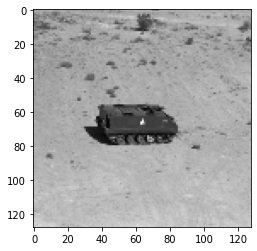

In [80]:
I_big = mpimg.imread(APC)
# halfing the image size to make calculations quicker
I = cv2.resize(I_big, (128,128))
plt.imshow(I)

## 1.

In [81]:
def DFT(I_OG):
  I = np.zeros(I_OG.shape, dtype = 'complex_')
  N, M = I_OG.shape

  W_i = np.exp(-2 * np.pi * 1j * np.arange(N) / N)
  W_j = np.exp(-2 * np.pi * 1j * np.arange(M) / M)


  # converting the double summation to a matrix multiplication for faster results
  for u in range(N):
    for v in range(M):
      temp = np.transpose(np.power(W_j, v))
      temp = np.dot(I_OG, temp)
      I[u, v] = np.multiply(temp, np.power(W_i, u)).sum()

  return I

I_analysis = DFT(I)

In [82]:
def IDFT(I_OG):

  I = np.zeros(I_OG.shape, dtype = 'complex_')
  N, M = I_OG.shape

  W_i = np.exp(2 * np.pi * 1j * np.arange(N) / N)
  W_j = np.exp(2 * np.pi * 1j * np.arange(M) / M)


  # converting the double summation to a matrix multiplication for faster results
  for u in range(N):
    for v in range(M):
      temp = np.transpose(np.power(W_j, v))
      temp = np.dot(I_OG, temp)
      I[u, v] = np.multiply(temp, np.power(W_i, u)).sum()

  I = I / (M * N)
  return I

I_synthesis = DFT(I_analysis)

## 2.

In [83]:
def DFT_matrix(I_OG):

  N, M = I_OG.shape
  W = np.ones(I_OG.shape, dtype = 'complex_')
  W[1, :] = np.exp(-2 * np.pi * 1j / N)
  W[1, :] = [x ** i for i, x in enumerate(W[1, :])]
  
  for i in range(2, N):
    W[i, :] = np.power(W[1, :], i)

  I_tilde = np.dot(W, np.dot(I_OG, W))
  return I_tilde
  
I_tilde = DFT_matrix(I)

In [110]:
def IDFT_matrix(I_OG):

  N, M = I_OG.shape
  W = np.ones(I_OG.shape, dtype = 'complex_')
  W[1, :] = np.exp(-2 * np.pi * 1j / N)
  W[1, :] = [x ** i for i, x in enumerate(W[1, :])]
  
  for i in range(2, N):
    W[i, :] = np.power(W[1, :], i)

  W = np.power(W, -1)
  W = W / N

  I = np.dot(W, np.dot(I_OG, W))
  return I
  
I_reg = IDFT_matrix(I_tilde)

## Magnitude and Phase

In [85]:
def linearPointOp(I, P, L):
  J = P * I + L
  J = J.astype(int)
  J = np.clip(J, 0, 255)
  return J

def FSCS(I):
  A, B = np.amin(I), np.amax(I)

  K = 256
  P = (K - 1) / (B - A)
  L = -1 * A * P
  output = linearPointOp(I, P, L)
  return output

def logRangeCompression(I):
  J = np.log(1 + I)
  output = FSCS(J)
  return output

In [111]:
def mag_phase(I):
  I_real = I.real
  I_imag = I.imag

  magnitude = np.sqrt(np.power(I_real, 2) + np.power(I_imag, 2))
  phase = np.angle(I)

  return magnitude, phase

Text(0.5, 1.0, 'Log Compressed Magnitude')

<Figure size 432x288 with 0 Axes>

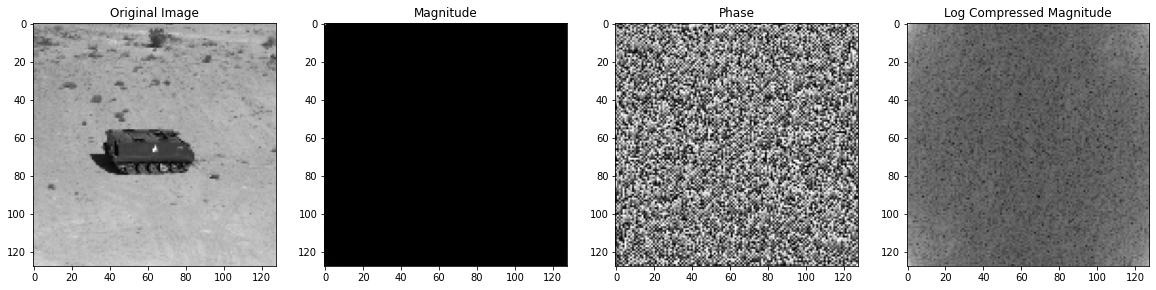

In [87]:
plt.figure()
fig, axs = plt.subplots(1, 4, figsize=(20, 40))

M, P = mag_phase(I_analysis)
M_log = logRangeCompression(M)

axs[0].imshow(I)
axs[1].imshow(M)
axs[2].imshow(P)
axs[3].imshow(M_log)


axs[0].set_title("Original Image")
axs[1].set_title("Magnitude")
axs[2].set_title("Phase")
axs[3].set_title("Log Compressed Magnitude")

## Centered DFT

In [88]:
def centerDFT(I_OG):
  I = np.zeros(I_OG.shape, dtype = 'complex_')
  N, M = I_OG.shape

  W_i = np.exp(-2 * np.pi * 1j * np.arange(N) / N)
  W_j = np.exp(-2 * np.pi * 1j * np.arange(M) / M)

  I_new = np.zeros((N, M))

  for i in range(N):
    for j in range(M):
      I_new[i, j] = I_OG[i, j] * ((-1)**(i+j)) 


  # converting the double summation to a matrix multiplication for faster results
  for u in range(N):
    for v in range(M):
      temp = np.transpose(np.power(W_j, v))
      temp = np.dot(I_new, temp)
      I[u, v] = np.multiply(temp, np.power(W_i, u)).sum()

  return I

I_center = centerDFT(I)

Text(0.5, 1.0, 'Log Compressed Magnitude')

<Figure size 432x288 with 0 Axes>

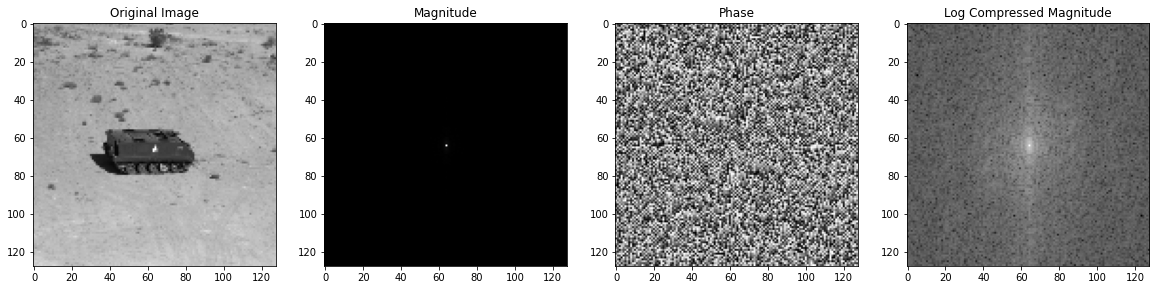

In [89]:
plt.figure()
fig, axs = plt.subplots(1, 4, figsize=(20, 40))

M, P = mag_phase(I_center)
M_log = logRangeCompression(M)

axs[0].imshow(I)
axs[1].imshow(M)
axs[2].imshow(P)
axs[3].imshow(M_log)


axs[0].set_title("Original Image")
axs[1].set_title("Magnitude")
axs[2].set_title("Phase")
axs[3].set_title("Log Compressed Magnitude")

## Verification

[[3.63797881e-12-1.95043981e-12j 3.42481599e-12-2.06767936e-12j
  3.41060513e-12-2.18136620e-12j ... 4.86011231e-12+2.80664381e-12j
  4.83169060e-12-2.94519964e-12j 3.86535248e-12-1.22923893e-12j]
 [3.51008111e-12-2.14228635e-12j 3.46744855e-12-2.27018404e-12j
  3.25428573e-12-2.37321274e-12j ... 4.37694325e-12+2.55617749e-12j
  4.51905180e-12-3.11217718e-12j 3.49587026e-12-1.60760294e-12j]
 [3.35376171e-12-2.28794761e-12j 3.14059889e-12-2.38031816e-12j
  3.18323146e-12-2.51532128e-12j ... 4.12114787e-12+2.37143638e-12j
  4.54747351e-12-3.24540395e-12j 3.43902684e-12-1.97886152e-12j]
 ...
 [4.97379915e-12+2.96118685e-12j 4.83169060e-12+3.11928261e-12j
  4.91695573e-12+2.91855429e-12j ... 6.05382411e-12+7.68096697e-12j
  6.67910172e-12+1.37134748e-12j 5.40012479e-12+3.45501405e-12j]
 [5.14432941e-12-3.98259203e-12j 4.91695573e-12-3.95061761e-12j
  4.77484718e-12-4.04298817e-12j ... 6.16751095e-12+1.55075952e-12j
  6.70752343e-12-5.39657208e-12j 5.37170308e-12-3.42303963e-12j]
 [3.325340

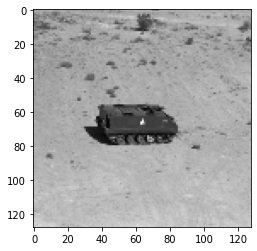

In [90]:
I_check = IDFT(DFT(I))
print(I_check - I)
plt.imshow(I_check.real)

print()

I_check = IDFT_matrix(DFT_matrix(I))
print(I_check - I)


print("\nAs we can see, these values are very close to zero (they aren't exactly zero due to floating point errors), hence the given condition is true.")

## Importance of Phase

In [91]:
M, P = mag_phase(DFT(I))

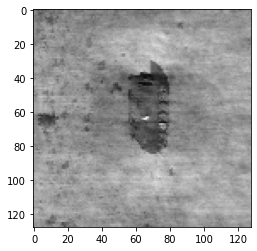

In [93]:
# transposing phase
I_temp = M * np.exp(1j * np.transpose(P))
I_inv = IDFT(I_temp)
plt.imshow(I_inv.real)

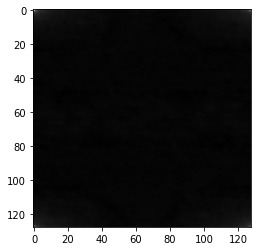

In [94]:
# setting phase to 0
I_temp = M * np.exp(1j * 0)
I_inv = IDFT(I_temp)
plt.imshow(I_inv.real)

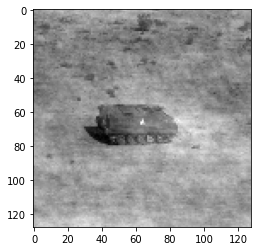

In [95]:
# adding Gaussian noise to phase
avg = 0
sigma = 1
noise = np.random.normal(avg, sigma, I.shape)

P_noisy = P + noise

I_temp = M * np.exp(1j * P_noisy)
I_inv = IDFT(I_temp)
plt.imshow(I_inv.real)

# 2. Periodic Convolution

## 1.

In [96]:
def convolution(I1, I2):

  N1, M1 = I1.shape
  N2, M2 = I2.shape

  result = np.zeros((N1, M1))

  for i in range(N1):
    for j in range(M1):
      for p in range(N2):
        for q in range(M2):
           result[i, j] = result[i, j] + I1[(i - p) % N1, (j - q) % M1] *  I2[p, q]    
  return result

Text(0.5, 1.0, 'Convolved APC')

<Figure size 432x288 with 0 Axes>

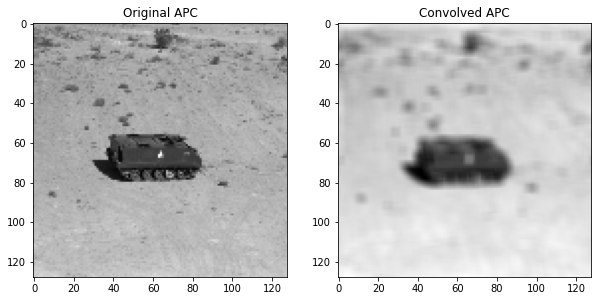

In [112]:
filter = np.ones((5, 5)) / 25

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(10, 20))

axs[0].imshow(I)
axs[1].imshow(convolution(I, filter))

axs[0].set_title("Original APC")
axs[1].set_title("Convolved APC")

Text(0.5, 1.0, 'Convolved Truck')

<Figure size 432x288 with 0 Axes>

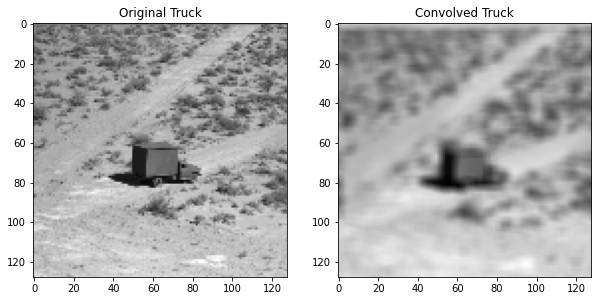

In [115]:
I_big_a = mpimg.imread(truck)
I_a = cv2.resize(I_big_a, (128, 128))

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(10, 20))

axs[0].imshow(I_a)
axs[1].imshow(convolution(I_a, filter))

axs[0].set_title("Original Truck")
axs[1].set_title("Convolved Truck")

Text(0.5, 1.0, 'Convolved Airport')

<Figure size 432x288 with 0 Axes>

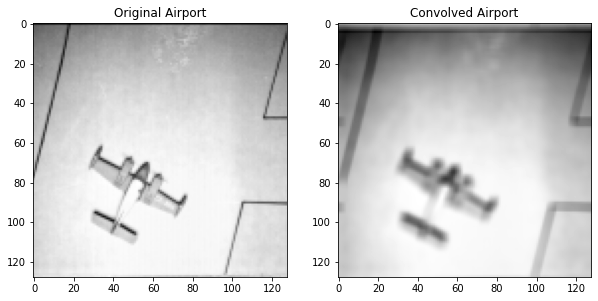

In [116]:
I_big_b = mpimg.imread(airplane)
I_b = cv2.resize(I_big_b, (128, 128))

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(10, 20))

axs[0].imshow(I_b)
axs[1].imshow(convolution(I_b, filter))

axs[0].set_title("Original Airport")
axs[1].set_title("Convolved Airport")

## 2.

In [102]:
def convolutionPad(I1, I2):

  N1, M1 = I1.shape
  N2, M2 = I2.shape

  result = np.zeros((N1, M1))

  # zero padding
  padding = N2 // 2
  padded = np.zeros((N1 + padding * 2, M1 + padding * 2))
  padded[padding:-padding, padding:-padding] = I1
  

  # for i in range(N1):
  #   for j in range(M1):
  #     for p in range(N2):
  #       for q in range(M2):
  #          result[i, j] = result[i, j] + padded[(i - p), (j - q)] *  I2[p, q]    

  # for faster calculations
  for i in range(padding, N1 + padding):
    for j in range(padding, M1 + padding):
      result[i - padding, j - padding] = (np.multiply(I2, padded[i - padding: i + padding + 1, j - padding: j + padding + 1]).sum())
  return result

Text(0.5, 1.0, 'Linearly Convolved APC')

<Figure size 432x288 with 0 Axes>

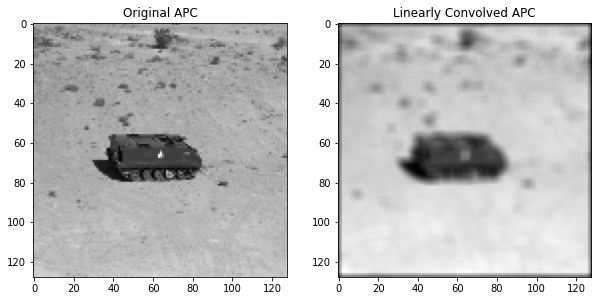

In [118]:
filter = np.ones((5, 5)) / 25

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(10, 20))

axs[0].imshow(I)
axs[1].imshow(convolutionPad(I, filter))

axs[0].set_title("Original APC")
axs[1].set_title("Linearly Convolved APC")

## 3.

Text(0.5, 1.0, 'Circularly Convolved APC ')

<Figure size 432x288 with 0 Axes>

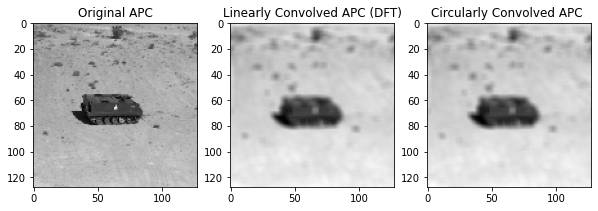

In [121]:
def linConv(I1, I2):
  N1, M1 = I1.shape
  N2, M2 = I2.shape

  result = np.zeros((N1, M1))

  # zero padding
  if N1 > N2:
    padded = np.zeros((N1, M1))
    padded[0:N2, 0:M2] = I2
  else:
    padded = I2

  J = IDFT(np.multiply(DFT(I1), DFT(padded)))
  return J

filter = np.ones((5, 5)) / 25
I_linConv = linConv(I, filter)

Visually, there's no difference between the outputs of 2.3 and 2.1 (APC), thus we've verified the given statement.


<Figure size 432x288 with 0 Axes>

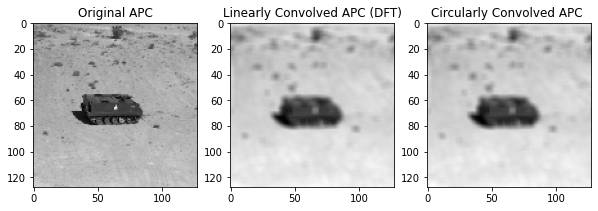

In [123]:
plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(10, 20))

axs[0].imshow(I)
axs[1].imshow(I_linConv.real)
axs[2].imshow(convolution(I, filter))


axs[0].set_title("Original APC")
axs[1].set_title("Linearly Convolved APC (DFT)")
axs[2].set_title("Circularly Convolved APC ")

print("Visually, there's no difference between the outputs of 2.3 and 2.1 (APC), thus we've verified the given statement.")

# 3. Image Denoising using Linear Filters

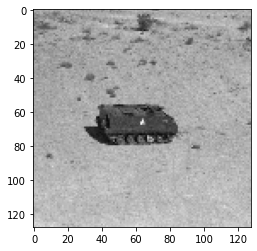

In [107]:
from google.colab.patches import cv2_imshow

avg = 0
sigma = 5
noise = np.random.normal(avg, sigma, I.shape)

I_noisy = I + noise
I_noisy = np.clip(I_noisy, 0, 255)
plt.imshow(I_noisy)

## 1.

M size: 3


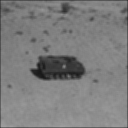

M size: 5


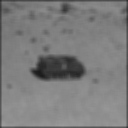

M size: 7


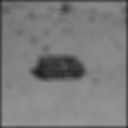

M size: 9


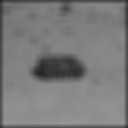

M size: 11


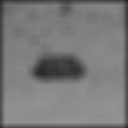

M size: 13


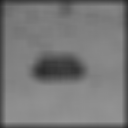

M size: 15


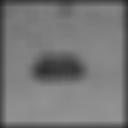

Upon visual inspection, when M = 3, the output seems to be the clearest. As M inclreases, the image gets more smoothed over and becomes very blurry.


In [108]:
def denoisingAVG(I):

  for i in range(3, 16, 2):
    M = np.ones((i, i))
    M = M / M.sum()

    I_denoised = convolutionPad(I, M)
    print("M size:", i)
    cv2_imshow(I_denoised)
denoisingAVG(I_noisy)
print("Upon visual inspection, when M = 3, the output seems to be the clearest. As M inclreases, the image gets more smoothed over and becomes very blurry.")

## 2.

sigma: 0.5


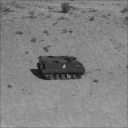

sigma: 1.0


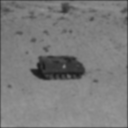

sigma: 1.5


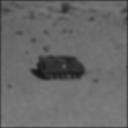

sigma: 2.0


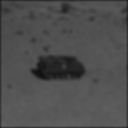

sigma: 2.5


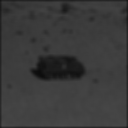

sigma: 3.0


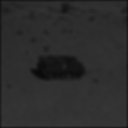

sigma: 3.5


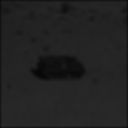

sigma: 4.0


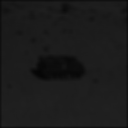

sigma: 4.5


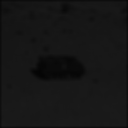

sigma: 5.0


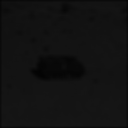

Upon visual inspection, when sigma = 0.5, the output seems to be the clearest. As sigma increases, the image starts to get more blurry and darker.


In [109]:
def denoisingGAUSS(I):

  for i in range(1, 11):
    M = np.zeros((5, 5))
    sigma = i/2

    for x in range(-2, 3):
      for y in range(-2, 3):
        numerator = np.exp(-((x**2) + (y**2)) / (2 * (sigma**2)))
        denominator = 2 * np.pi * (sigma**2)
        M[x + 2, y + 2] = numerator / denominator

    I_denoised = convolutionPad(I, M)
    print("sigma:", sigma)
    cv2_imshow(I_denoised)

denoisingGAUSS(I_noisy)
print("Upon visual inspection, when sigma = 0.5, the output seems to be the clearest. As sigma increases, the image starts to get more blurry and darker.")